In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import InstructionProperties
from qiskit.visualization import plot_distribution
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.primitives import StatevectorEstimator

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions
)

In [4]:
import qc_grader

qc_grader.__version__

'0.18.12'

In [5]:
from qc_grader.challenges.iqc_2024 import (
    grade_lab4_ex1,
    grade_lab4_ex2,
    grade_lab4_ex3,
    grade_lab4_ex4,
    grade_lab4_ex5,
    grade_lab4_ex6,
    grade_lab4_ex7
)

In [6]:
# Define num_qubits, the number of qubits, for the rest of the Lab
num_qubits = 5

# Load the dictionary 
birds_dataset = pd.read_csv('birds_dataset.csv') 

# Check if the dataset is loaded correctly - coefficients should be complex numbers
for i in range(2**num_qubits):
    key = 'c%.0f' %i
    birds_dataset[key] = birds_dataset[key].astype(np.complex128)

# Print the dataset
birds_dataset

,names,c0,c1,c2,c3,c4,c5,c6,c7,c8,...,c22,c23,c24,c25,c26,c27,c28,c29,c30,c31
0,Falcon,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j
1,Hummingbird,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j
2,Eagle,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j
3,Osprey,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
4,Heron,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
5,Peacock,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
6,Parrot,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
7,Swan,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
8,Toucan,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
9,Cardinal,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j


In [33]:
ibm_quantum_birds = ["Falcon", "Hummingbird", "Eagle", "Osprey", "Heron"]
df = birds_dataset
list_coefficients = [[i for i in row[2:]] for row in df.itertuples()]
list_labels = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

In [34]:
grade_lab4_ex1(list_coefficients, list_labels)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


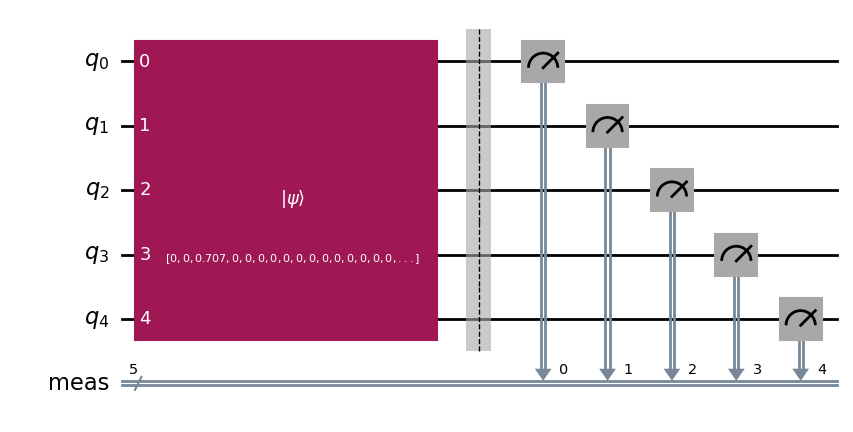

In [35]:
index_bird = 2 # You can check different birds by changing the index
amplitudes = list_coefficients[index_bird]

# Build the amplitude embedding 
qc = QuantumCircuit(5)
qc.initialize(amplitudes, range(num_qubits))
qc.measure_all()

# Draw the amplitude embedding circuit
qc.draw(output="mpl")

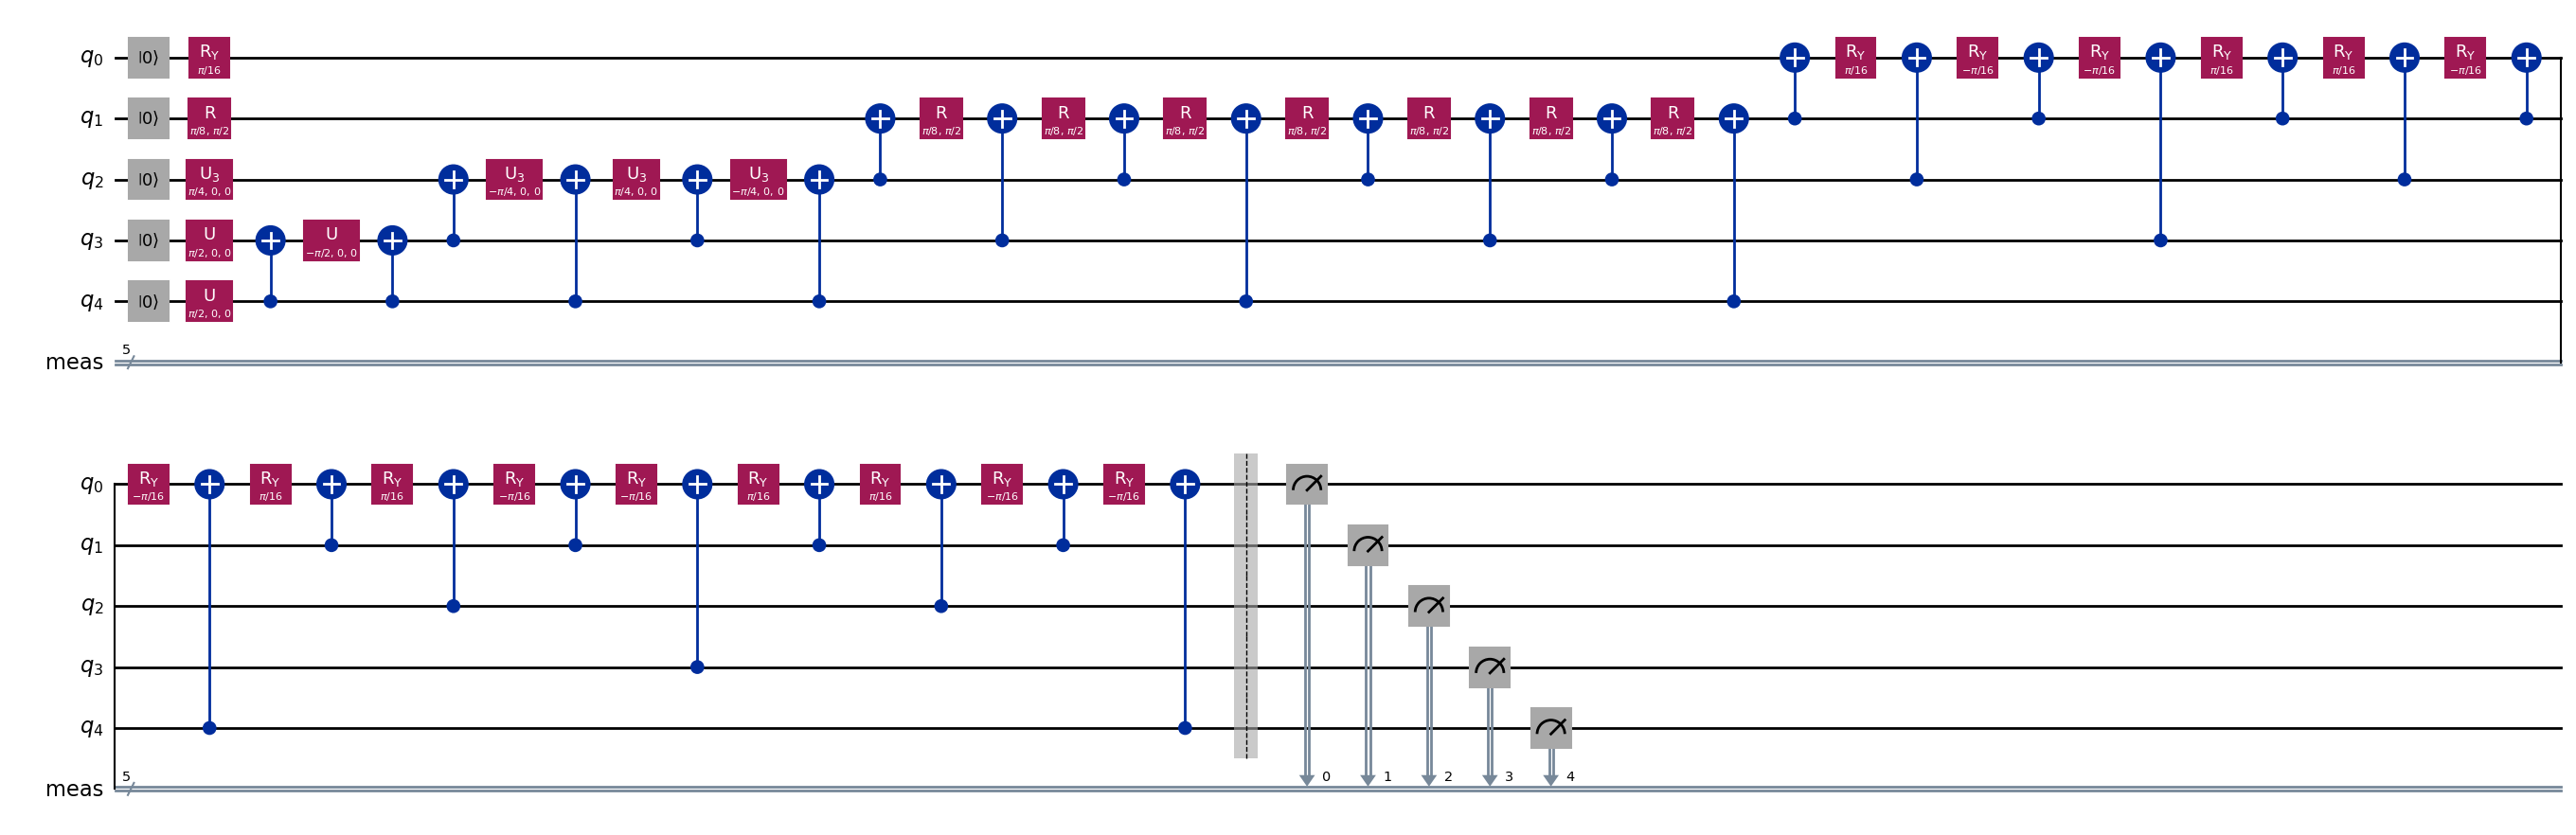

In [36]:
qc.decompose(reps=8).draw(output="mpl", fold=40)

In [61]:
num_qubits = 5
reps = 1
entanglement = 'full'
ansatz = RealAmplitudes(num_qubits, entanglement, reps)
print(ansatz)

     ┌────────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                                   ├
     │                                                                    │
q_1: ┤1                                                                   ├
     │                                                                    │
q_2: ┤2 RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9]) ├
     │                                                                    │
q_3: ┤3                                                                   ├
     │                                                                    │
q_4: ┤4                                                                   ├
     └────────────────────────────────────────────────────────────────────┘


In [41]:
grade_lab4_ex2(num_qubits, reps, entanglement)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [62]:
# Define the observable 
obs = SparsePauliOp("ZZZZZ")
# Define the estimator and pass manager
estimator = StatevectorEstimator() #To train we use StatevectorEstimator to get the exact simulation
pm = generate_preset_pass_manager(backend=AerSimulator(), optimization_level=3, seed_transpiler=0)

In [63]:
def cost_func(params, list_coefficients, list_labels, ansatz, obs, estimator, pm, callback_dict):

    """Return cost function for optimization

    Parameters:
        params (ndarray): Array of ansatz parameters
        list_coefficients (list): List of arrays of complex coefficients
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        estimator (EstimatorV2): Statevector estimator primitive instance
        pm (PassManager): Pass manager
        callback_dict (dict): Dictionary to store callback information

    Returns:
        float: Cost function estimate
    """

    cost = 0
    for amplitudes,label in zip(list_coefficients, list_labels):
        qc = QuantumCircuit(num_qubits)
        # Amplitude embedding
        qc.initialize(amplitudes)
        # Compose initial state + ansatz
        classifier = qc.compose(ansatz) 
        # Transpile classifier
        transpiled_classifier = pm.run(classifier)
        # Transpile observable
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        # Run estimator
        pub = (transpiled_classifier, transpiled_obs, params)
        job = estimator.run([pub])
        # Get result
        result = job.result()[0].data.evs
        # Compute cost function (cumulative)
        cost += np.abs(result - label)

    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = params
    callback_dict["cost_history"].append(cost)

    # Print the iterations to screen on a single line
    print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], cost),
        end="\r",
        flush=True,
    )
    
    return cost

In [64]:
# Intialize the lists to store the results from different runs
cost_history_list = []
res_list = []

# Retrieve the initial parameters
params_0_list = np.load("params_0_list.npy")

for it, params_0 in enumerate(params_0_list):

    print('Iteration number: ', it)
    # Initialize a callback dictionary
    callback_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
    }

    # Minimize the cost function using scipy
    res = minimize(
        cost_func, 
        params_0, 
        args=(list_coefficients, list_labels, ansatz, obs, estimator, pm, callback_dict), 
        method="cobyla", # Classical optimizer
        options={'maxiter': 200}) # Maximum number of iterations
    
    # Print the results after convergence
    print(res)

    # Save the results from different runs
    res_list.append(res)
    cost_history_list.append(callback_dict["cost_history"])

Iteration number:  0
 message: Optimization terminated successfully.82]]
 success: True
  status: 1
     fun: 4.057929433107382
       x: [ 3.739e+00 -1.799e-01  2.141e-02  3.719e+00  4.955e+00
            1.571e+00  2.475e-06  6.028e+00  2.534e+00  3.102e+00]
    nfev: 195
   maxcv: 0.0
Iteration number:  1
 message: Optimization terminated successfully.41]]
 success: True
  status: 1
     fun: 5.000060186657541
       x: [ 4.356e-03 -1.542e-04  3.449e-01 -3.696e-01  1.871e+00
            6.839e-01  1.566e+00  1.227e+00  1.105e+00 -9.954e-02]
    nfev: 117
   maxcv: 0.0
Iteration number:  2
 message: Optimization terminated successfully.53]]
 success: True
  status: 1
     fun: 4.095589526823153
       x: [ 4.031e+00  3.166e+00  3.205e+00  3.386e+00  1.022e+00
            2.308e+00  3.131e+00  3.057e+00  3.192e+00  2.573e+00]
    nfev: 139
   maxcv: 0.0
Iteration number:  3
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 4.4277

In [47]:
print(cost_history_list[0])

[5.470744530326589, 5.450473479021102, 5.975022266499196, 5.6714455508899535, 5.735394280641521, 5.2327506044103, 5.142139133954793, 6.196614004630433, 5.154893261390285, 5.113986469402498, 5.121307690076967, 4.443313271145341, 4.480508300356454, 4.601064475956831, 5.217122598762173, 4.435722060853823, 4.327328442125924, 4.440050935389945, 5.517908790609558, 5.009371474594378, 4.567299254522038, 4.600505939733993, 4.9254115433951355, 6.264017183149944, 4.397598027166123, 4.370749878668024, 4.43352644143839, 4.32195295618864, 4.5386554249143485, 4.516363156752729, 4.5999225333036575, 4.505840054573989, 4.349690849987635, 4.490335946976901, 4.321313565512332, 4.439986776300714, 4.32964977914224, 4.338791143366435, 4.342952281572905, 4.344151357480139, 4.362109048655911, 4.343649955641758, 4.378201466862437, 4.385273007504477, 4.312379791552818, 4.347581500950604, 4.321441187509754, 4.30169806418634, 4.322415168403057, 4.247560211416935, 4.23700521093514, 4.230279380865008, 4.192697573363

In [52]:
def test_VQC(list_coefficients, list_labels, ansatz, obs, opt_params, estimator, pm):
    result_test = []
    for amplitudes,label in zip(list_coefficients, list_labels):
        qc = QuantumCircuit(num_qubits)
        # Amplitude embedding
        qc.initialize(amplitudes)
        # Compose initial state + ansatz
        classifier = qc.compose(ansatz) 
        # Transpile classifier
        transpiled_classifier = pm.run(classifier)
        # Transpile observable
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        # Run estimator
        pub = (transpiled_classifier, transpiled_obs, opt_params)
        job = estimator.run([pub])
        # Get result
        result = job.result()[0].data.evs
        # Compute cost function (cumulative)
        result_test.append(np.abs(result - label))
    return result_test

In [77]:
def compute_performance(result_list, list_labels):
    
    """Return the performance of the classifier

    Parameters:
        result_list (list): List of results
        list_labels (list): List of labels
        
    Returns:
        float: Performance of the classifier
    """
    summ = 0
    ### Write your code below here ###
    for index in range(len(list_labels)):
        summ += abs(result_list[index]-list_labels[index])
    
    performance = 100-100*summ/(2**5)
        
    ### Don't change any code past this line ###                                    
    return performance

Performance for trial 0: 92.47581447522121
Performance for trial 1: 99.98437804364505
Performance for trial 2: 85.90778324884047
Performance for trial 3: 97.40715529313321
Performance for trial 4: 84.37500530358044


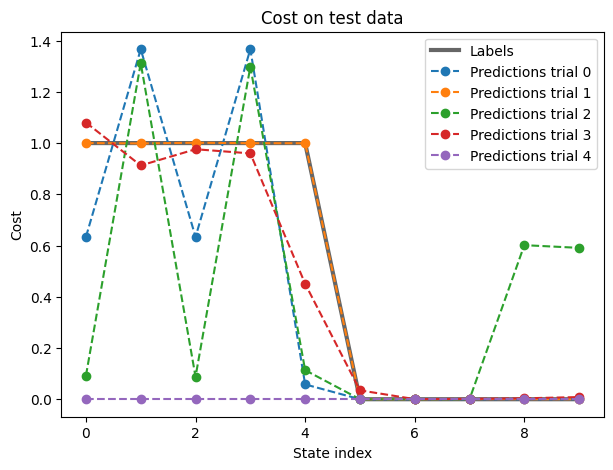

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

ax.plot(list_labels, 'k-', linewidth=3, alpha=0.6, label='Labels')

for index in range(len(res_list)):
    opt_params = res_list[index].x
    results_test = test_VQC(list_coefficients, list_labels, ansatz, obs, opt_params, estimator, pm)
    print(f"Performance for trial {index}: {compute_performance(results_test, list_labels)}")
    ax.plot(results_test, 'o--', label='Predictions trial '+str(index))

ax.legend()

In [83]:
best_result_index = 4 # Choose the index with the best result
grade_lab4_ex3(res_list[best_result_index]) # Expected result type: OptimizeResult

Submitting your answer. Please wait...
Performance: 100.00% > 90%
Congratulations! 🎉 Your answer is correct.


In [84]:
fake_backend = GenericBackendV2(
    num_qubits=5,
    basis_gates=["id", "rz", "sx", "x", "cx"]
  )

In [85]:
def update_error_rate(backend, error_rates):

    """Updates the error rates of the backend

    Parameters: 
        backend (BackendV2): Backend to update
        error_rates (dict): Dictionary of error rates

    Returns:    
        None
    """

    default_duration=1e-8
    if "default_duration" in error_rates:
        default_duration = error_rates["default_duration"]

    # Update the 1-qubit gate properties 
    for i in range(backend.num_qubits):
        qarg = (i,)
        if "rz_error" in error_rates:
            backend.target.update_instruction_properties('rz', qarg, InstructionProperties(error=error_rates["rz_error"], duration=default_duration))
        if "x_error" in error_rates:
            backend.target.update_instruction_properties('x', qarg, InstructionProperties(error=error_rates["x_error"], duration=default_duration))
        if "sx_error" in error_rates:
            backend.target.update_instruction_properties('sx', qarg, InstructionProperties(error=error_rates["sx_error"], duration=default_duration)) 
        if "measure_error" in error_rates:
            backend.target.update_instruction_properties('measure', qarg, InstructionProperties(error=error_rates["measure_error"], duration=default_duration))            
    
    # Update the 2-qubit gate properties (CX gate) for all edges in the chosen coupling map
    if "cx_error" in error_rates:    
        for edge in backend.coupling_map:
            backend.target.update_instruction_properties('cx', tuple(edge), InstructionProperties(error=error_rates["cx_error"], duration=default_duration))

In [86]:
error_rates = {
  "default_duration": 1e-8,
  "rz_error": 1e-8,
  "x_error": 1e-8,
  "sx_error": 1e-8,
  "measure_error": 1e-8,
  "cx_error": 1e-8
}

update_error_rate(fake_backend, error_rates)

Performance for run 4: 99.67498779296875
Performance for run 4: 99.4598388671875
Performance for run 4: 97.509765625
Performance for run 4: 97.46551513671875


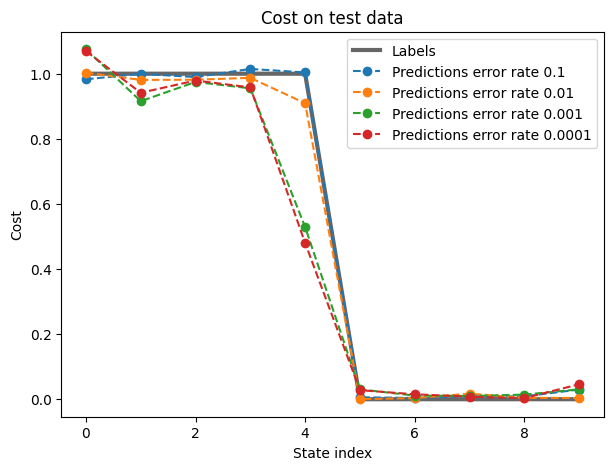

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')
ax.plot(list_labels, 'k-', linewidth=3, alpha=0.6, label='Labels')

error_rate_list = [1e-1, 1e-2, 1e-3, 1e-4]

fake_backend = GenericBackendV2(
    num_qubits=5,
    basis_gates=["id", "rz", "sx", "x", "cx"]
  )

for error_rate_value in error_rate_list:
    error_rates = {
      "default_duration": 1e-8,
      "rz_error": error_rate_value,
      "x_error": 1e-8,
      "sx_error": 1e-8,
      "measure_error": 1e-8,
      "cx_error": error_rate_value
                    }
    update_error_rate(fake_backend, error_rates)

    estimator = Estimator(backend = fake_backend)
    pm = generate_preset_pass_manager(backend=fake_backend, optimization_level=3)

    opt_params = res_list[3].x
    results_test = test_VQC(list_coefficients, list_labels, ansatz, obs, opt_params, estimator, pm)

    print(f"Performance for run {index}: {compute_performance(results_test, list_labels)}")
    ax.plot(results_test, 'o--', label='Predictions error rate '+str(error_rate_value))
    
ax.legend()

In [101]:
grade_lab4_ex4(fake_backend)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [103]:
# Choose a real backend
service = QiskitRuntimeService()
backend = service.backend("ibm_sherbrooke")

# Define a fake backend with the same properties as the real backend
fake_backend = AerSimulator.from_backend(backend)

Depth of two-qubit gates:  37


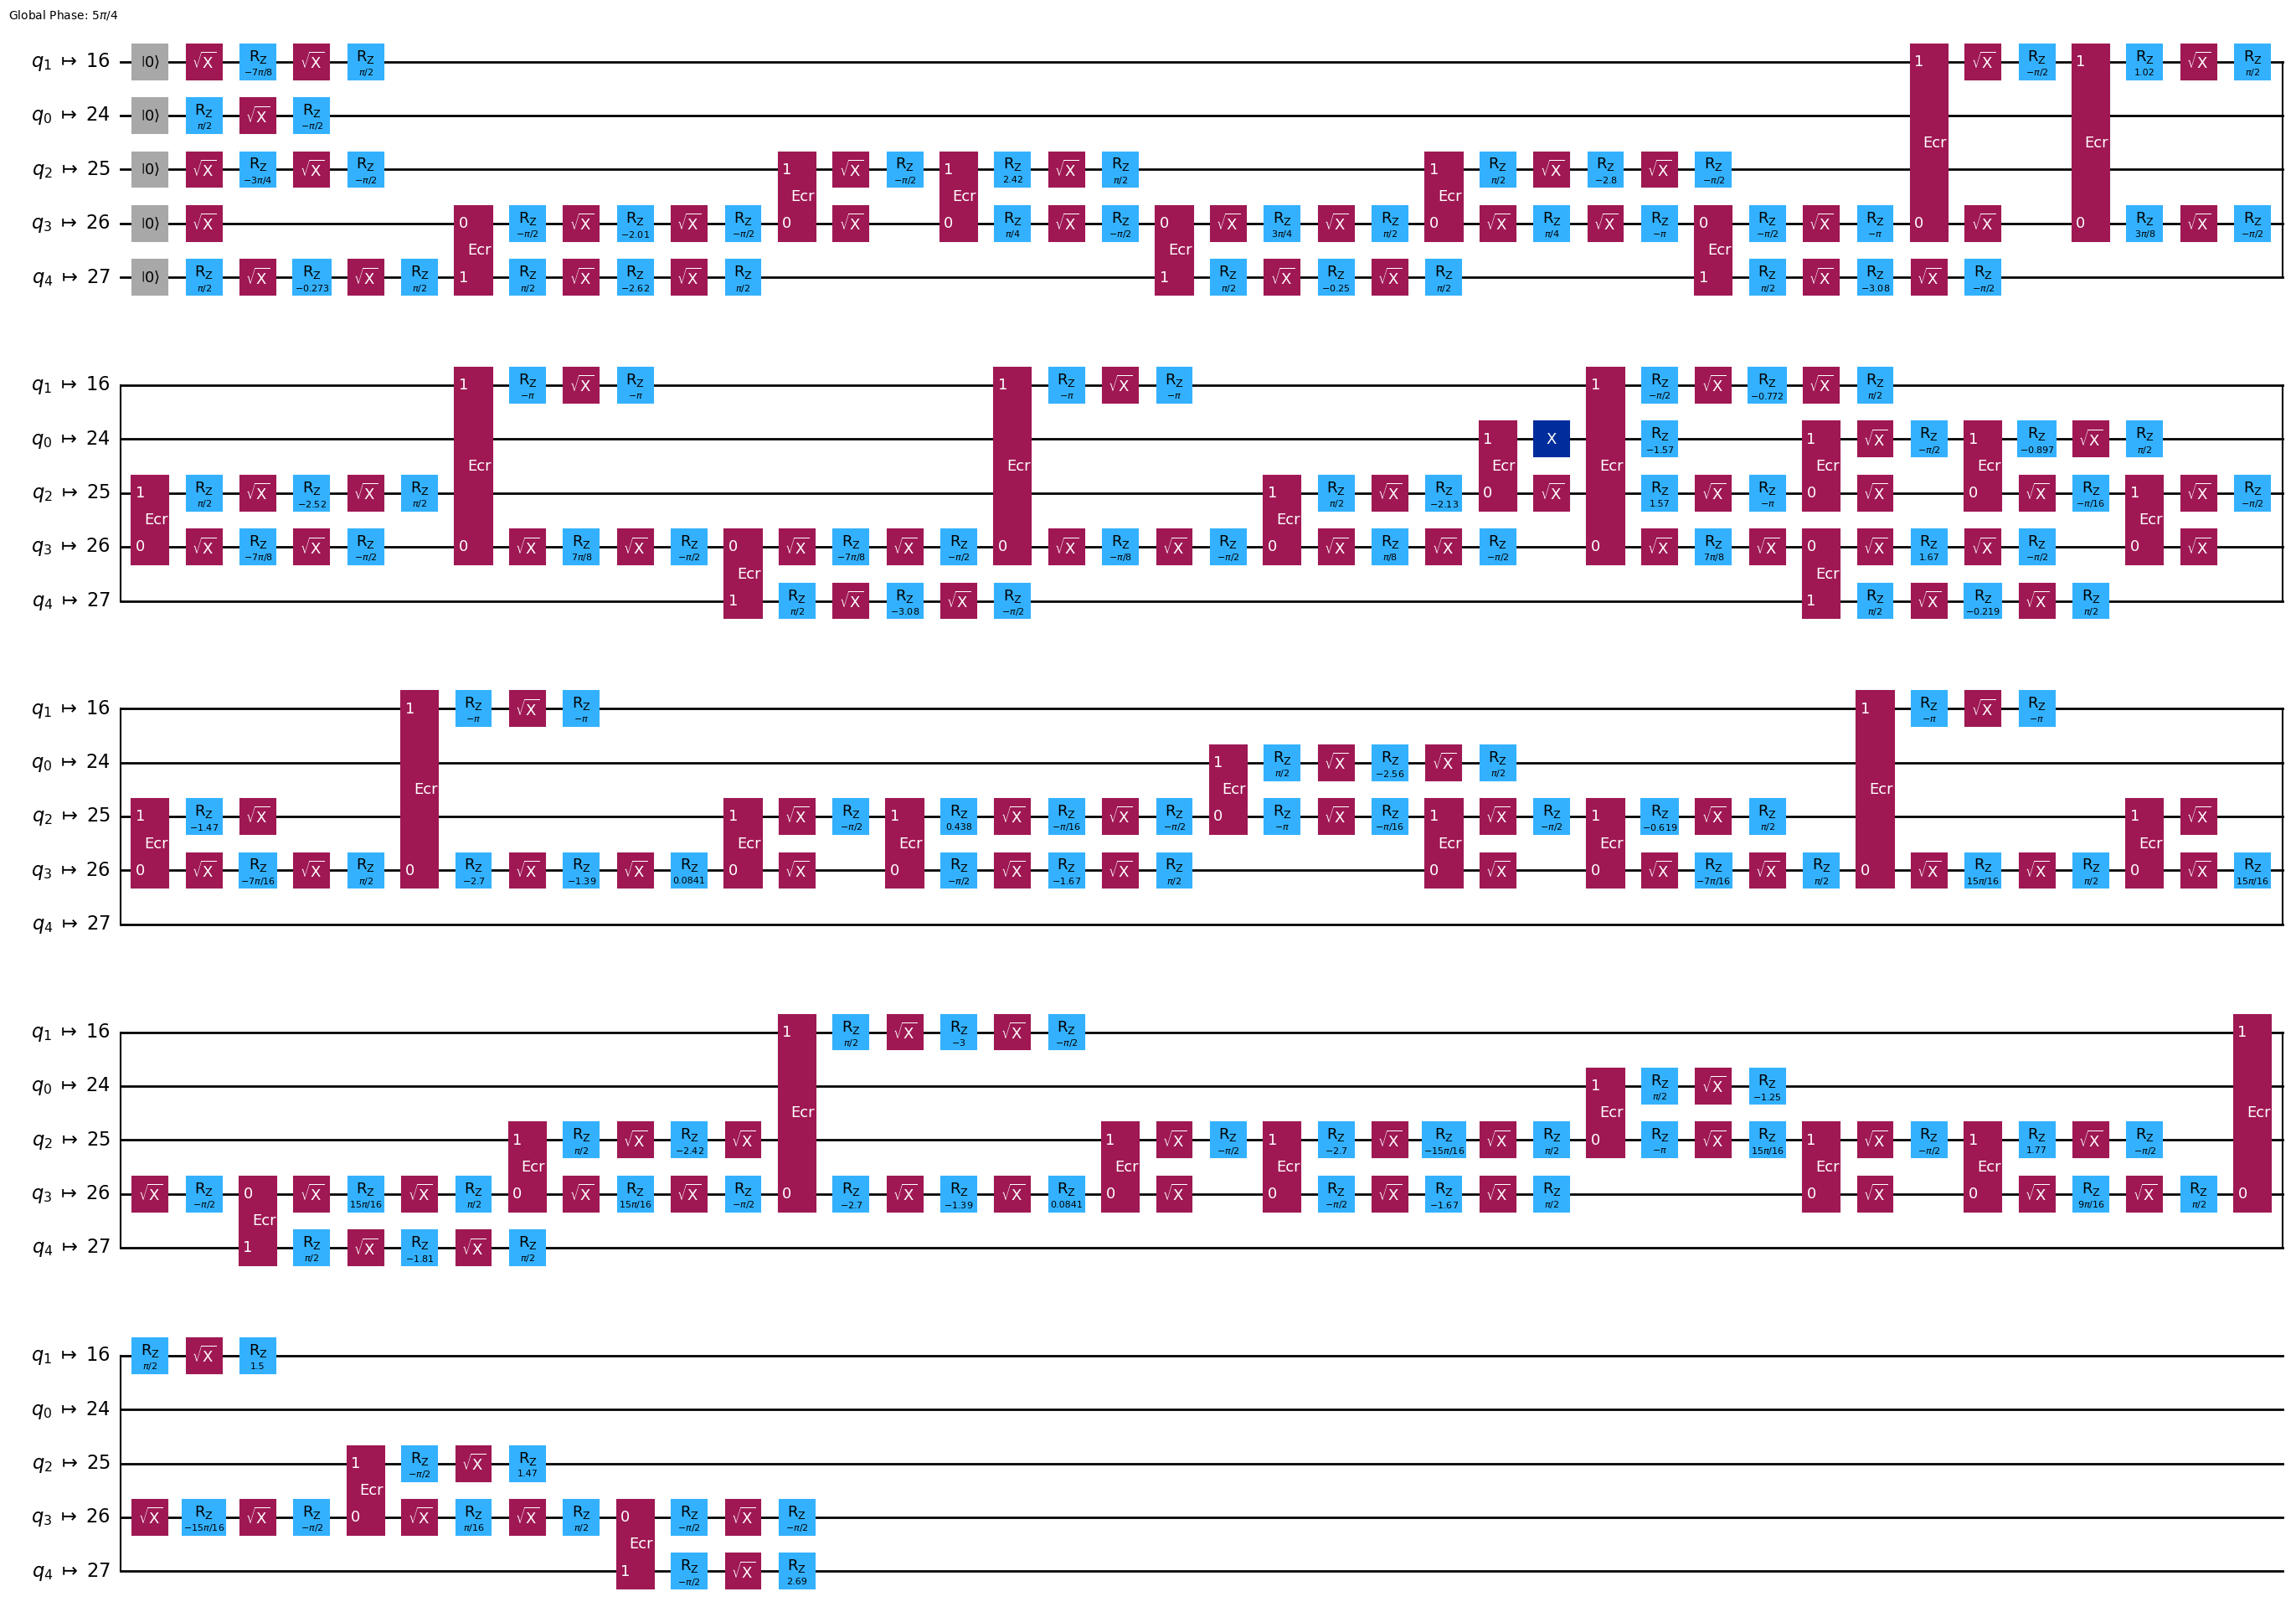

In [104]:
index_bird = 0 #you can check different birds by changing the index
qc = QuantumCircuit(num_qubits)
qc.initialize(list_coefficients[index_bird])
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
transpiled_qc.draw(output="mpl", idle_wires=False, fold=40)


In [130]:
def amplitude_embedding(num_qubits, bird_index):
    """Create amplitude embedding circuit

    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        bird_index (int): Data index of the bird

    Returns:
        qc (QuantumCircuit): Quantum circuit with amplitude embedding of the bird
    """
    def generate_GHZ(qc):
        qc.h(0)
        for i, j in zip(range(num_qubits-1), range(1,num_qubits)):
            qc.cx(i, j)
        return qc
    ### Write your code below here ###

    qc = QuantumCircuit(num_qubits)
    if bird_index <5:
        qc = generate_GHZ(qc)
    binary_string = bin(bird_index)[2:]
    
    # Pad the binary string with zeros to ensure a length of 5
    binary_string = binary_string.zfill(5)
    
    # Convert each digit of the binary string to a list
    for i in reversed(range(len(binary_string))):
        if binary_string[num_qubits-1-i] == '1':
            qc.x(i)
        
    ### Don't change any code past this line ###
    return qc

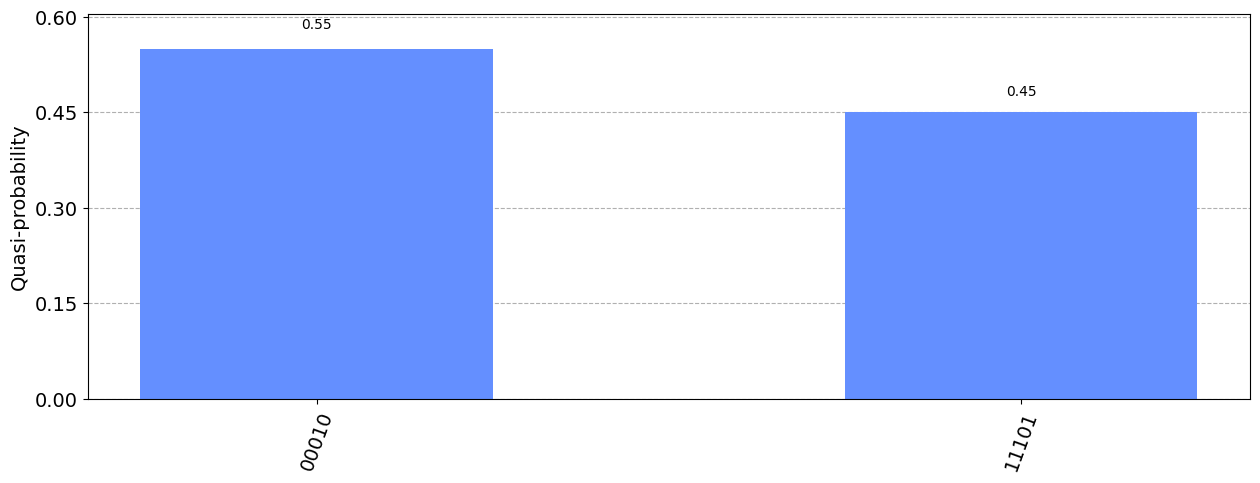

In [131]:
index_bird = 2 # You can check different birds by changing the index

# Build the amplitude embedding 
qc = amplitude_embedding(num_qubits, index_bird)
qc.measure_all()

# Define the backend and the pass manager
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)
isa_circuit = pm.run(qc)

# Define the sampler with the number of shots
sampler = Sampler(backend=aer_sim)
result = sampler.run([isa_circuit]).result()
samp_dist = result[0].data.meas.get_counts()
plot_distribution(samp_dist, figsize=(15, 5))

Depth of two-qubit gates:  4


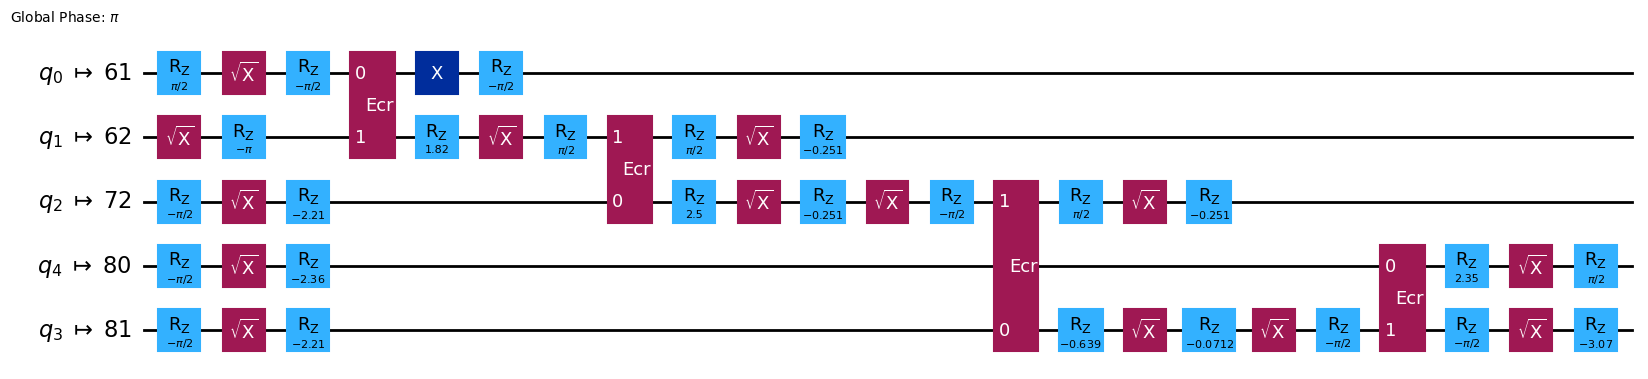

In [132]:
index_bird = 0 #You can check different birds by changing the index
qc = amplitude_embedding(num_qubits, index_bird)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
transpiled_qc.draw(output="mpl", fold=False, idle_wires=False)

In [133]:
grade_lab4_ex5(amplitude_embedding) # Expected answer type Callable


Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Depth of two-qubit gates:  18


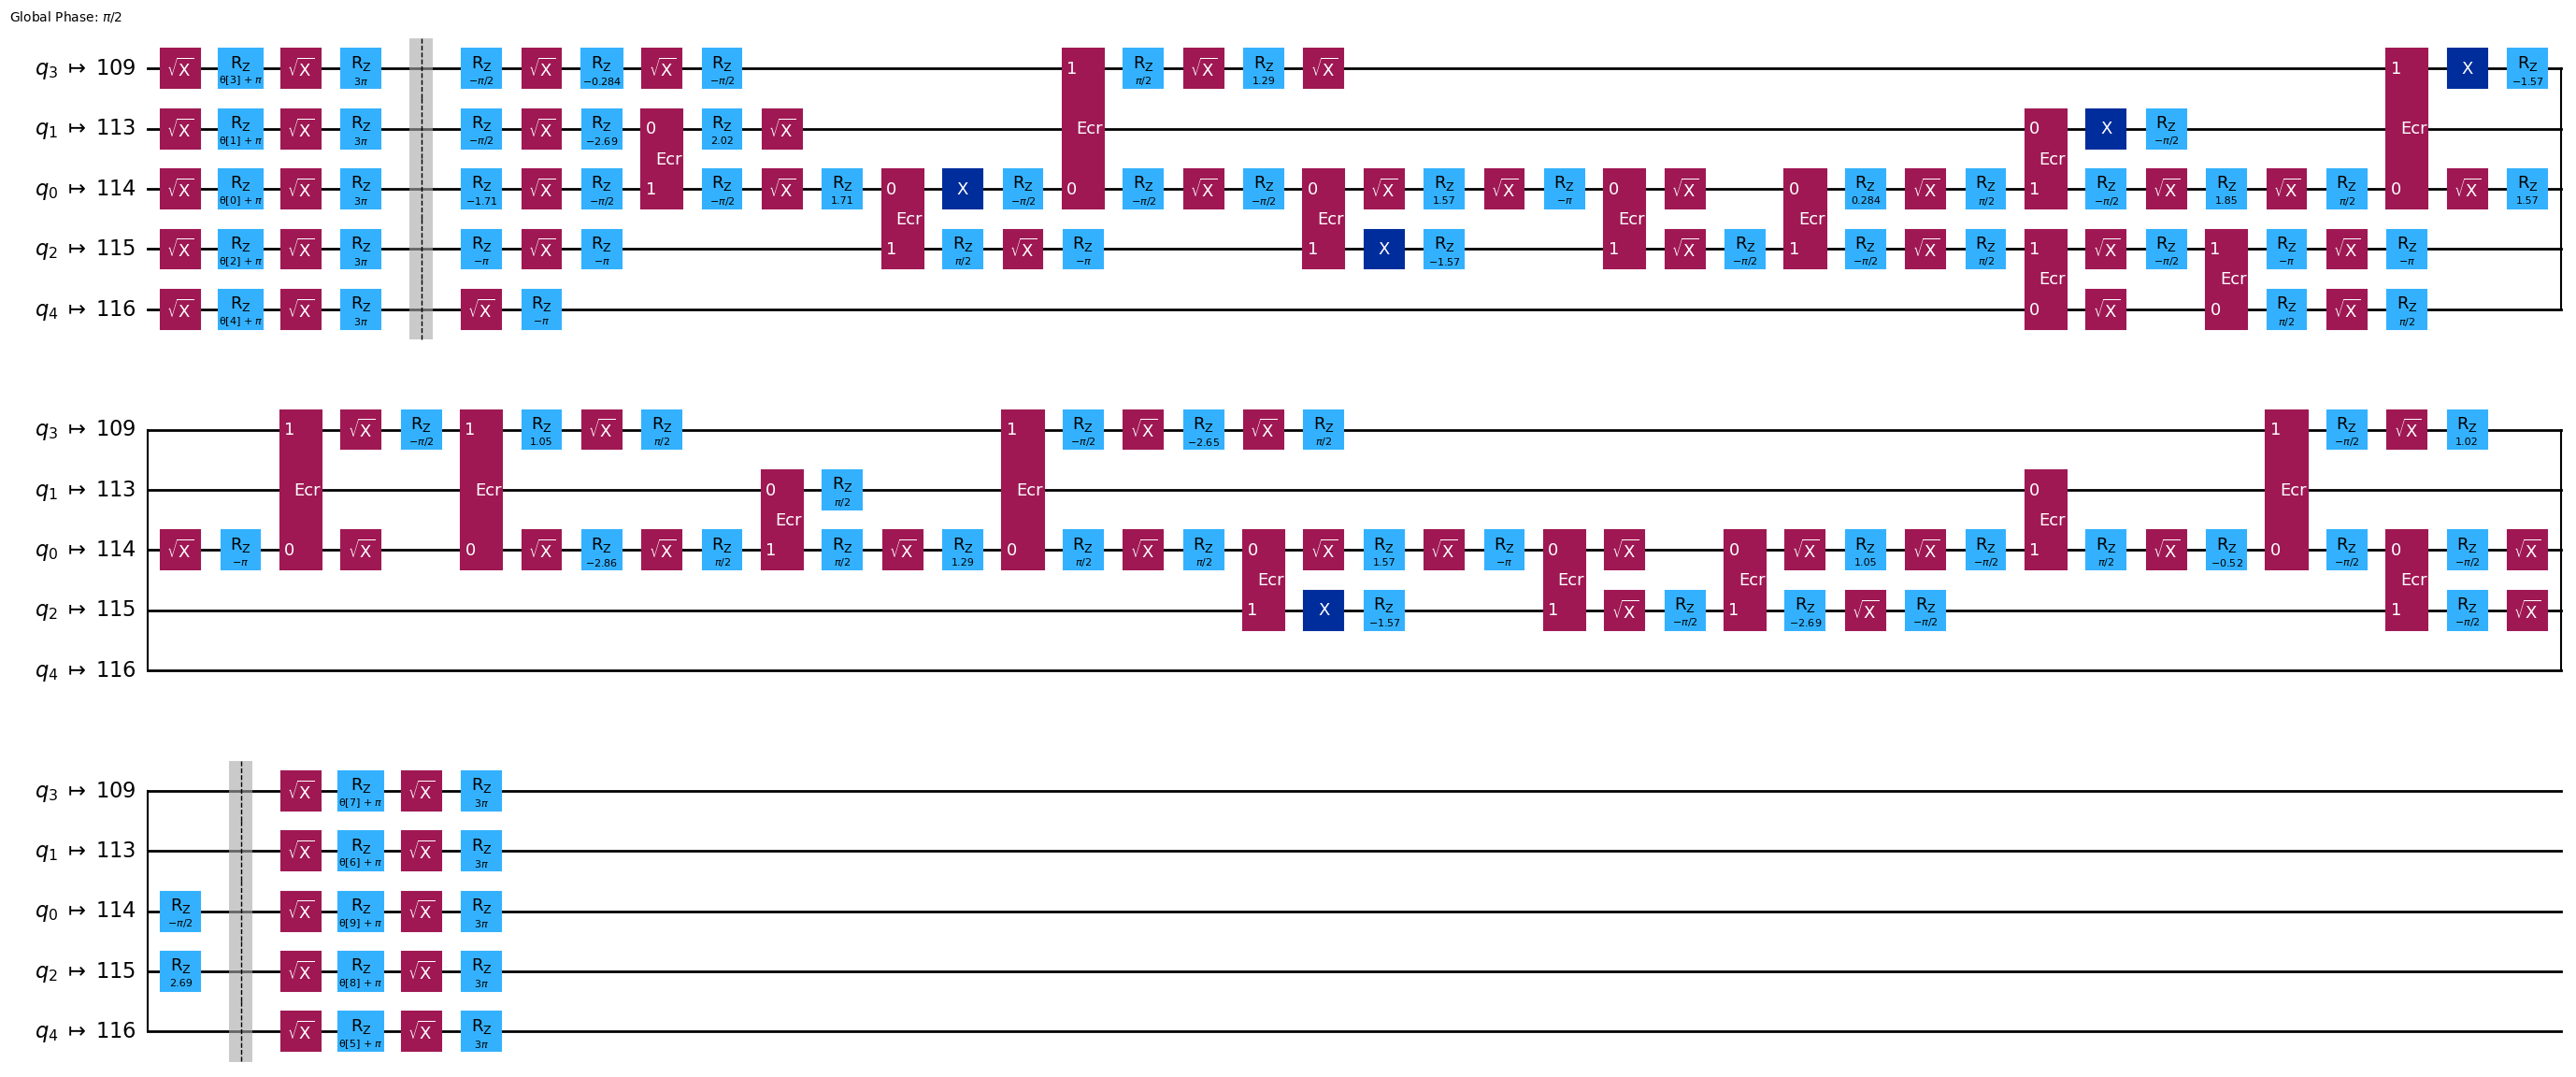

In [134]:
old_ansatz = RealAmplitudes(num_qubits, reps=1, entanglement='full', insert_barriers=True)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_ansatz = pm.run(old_ansatz)

print('Depth of two-qubit gates: ', transpiled_ansatz.depth(lambda x: len(x.qubits) == 2))
transpiled_ansatz.draw(output="mpl", idle_wires=False, fold=40)

In [176]:
ansatz = RealAmplitudes(num_qubits, reps=1, entanglement='pairwise', insert_barriers=True)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_ansatz = pm.run(ansatz)

Depth of two-qubit gates:  2


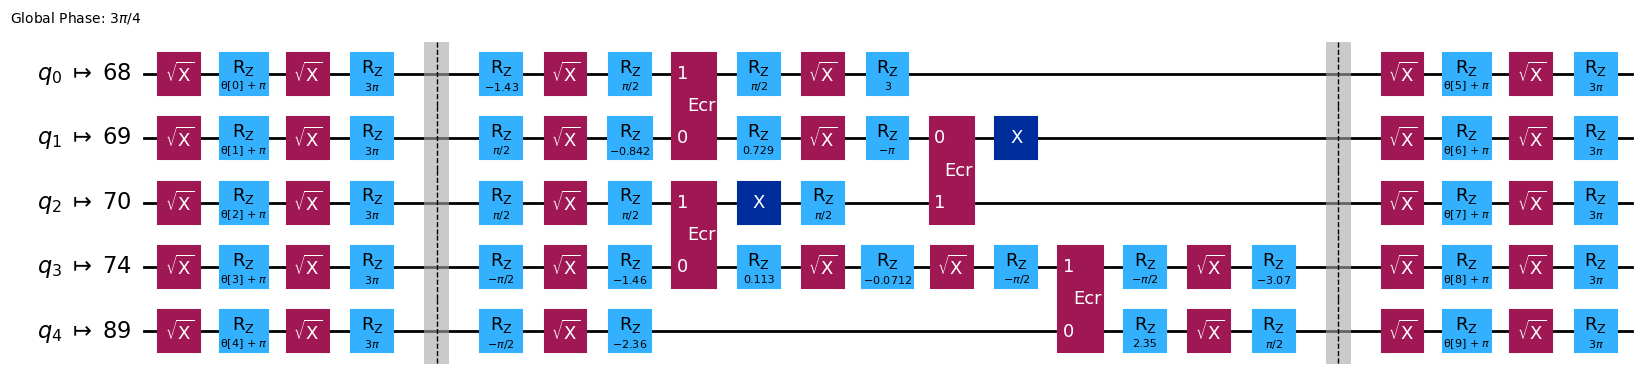

In [177]:
print('Depth of two-qubit gates: ', transpiled_ansatz.depth(lambda x: len(x.qubits) == 2))
transpiled_ansatz.draw(output="mpl", idle_wires=False, fold=40)

In [178]:
old_mapping = QuantumCircuit(num_qubits)
old_mapping.initialize(list_coefficients[index_bird])
old_classifier = old_mapping.compose(old_ansatz)

new_mapping = amplitude_embedding(num_qubits, index_bird)
new_classifier = new_mapping.compose(ansatz)

pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
old_transpiled_classifier = pm.run(old_classifier)
new_transpiled_classifier = pm.run(new_classifier)

print('Old depth of two-qubit gates: ', old_transpiled_classifier.depth(lambda x: len(x.qubits) == 2))
print('Current depth of two-qubit gates: ', new_transpiled_classifier.depth(lambda x: len(x.qubits) == 2))

Old depth of two-qubit gates:  66
Current depth of two-qubit gates:  6


In [179]:
def test_shallow_VQC(list_labels, ansatz, obs, opt_params, estimator, pm):
    
    """Return the performance of the classifier

    Parameters:
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        estimator (EstimatorV2): Statevector estimator
        pm (PassManager): Pass manager for transpilation 
        
    Returns:
        results_test (list): List of test results
    """
    results_test = []
    ### Write your code below here ###
    for label in list_labels:
        qc = QuantumCircuit(num_qubits)
        qc = amplitude_embedding(num_qubits, index_bird)
        classifier = qc.compose(ansatz) 
        transpiled_classifier = pm.run(classifier)
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        pub = (transpiled_classifier, transpiled_obs, opt_params)
        job = estimator.run([pub])
        result = job.result()[0].data.evs
        # Compute cost function (cumulative)
        results_test.append(np.abs(result - label))
    ### Don't change any code past this line ###                       
    return results_test

Performance: 74.09210205078125


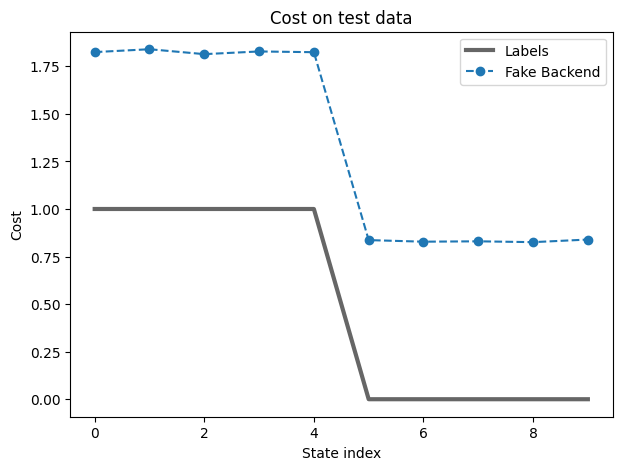

In [180]:
estimator = Estimator(backend=fake_backend)
estimator.options.default_shots = 5000
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)

opt_params = np.load('opt_params_shallow_VQC.npy') # Load optimal parameters
results_test = test_shallow_VQC(list_labels, ansatz, obs, opt_params, estimator, pm)

print(f"Performance: {compute_performance(results_test, list_labels)}")

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')
ax.plot(list_labels, 'k-', linewidth=3, alpha=0.6, label='Labels')
ax.plot(results_test, 'o--', label='Fake Backend')
ax.legend()

In [142]:
grade_lab4_ex6(results_test) # Expected answer type: list[float]


Submitting your answer. Please wait...
Performance: 99.10% > 70%
Congratulations! 🎉 Your answer is correct.


In [181]:
service = QiskitRuntimeService()
backend = service.backend("ibm_sherbrooke")

In [182]:
def test_shallow_VQC_QPU(list_labels, ansatz, obs, opt_params, options, backend):
    
    """Return the performance of the classifier

    Parameters:
        list_labels (list): List of labels 
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        options (EstimatorOptions): Estimator options
        backend (service.backend): Backend to run the job 
        
    Returns:
        job_id (str): Job ID
    """

    estimator = Estimator(backend=backend, options=options)
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

    pubs = []
    for bird, label in enumerate(list_labels):
        ### Write your code below here ###
        qc = QuantumCircuit(num_qubits)
        qc = amplitude_embedding(num_qubits, bird)
        classifier = qc.compose(ansatz) 
        transpiled_classifier = pm.run(classifier)
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
  
        ### Don't change any code past this line ###
        pub = (transpiled_classifier, transpiled_obs, opt_params)
        pubs.append(pub)

    job = estimator.run(pubs)
    job_id = job.job_id()
    print(f"Job ID: {job_id}")
    print(f"Status: {job.status()}")
                                           
    return job_id

In [183]:
## No DD, no TREX (no ZNE)
options_0 = EstimatorOptions()
options_0.optimization_level =0
options_0.resilience_level = 0
options_0.default_shots = 5000
options_0.dynamical_decoupling.enable = False
options_0.dynamical_decoupling.sequence_type = 'XpXm'
options_0.twirling.enable_measure = False

## DD + TREX (no ZNE)
options_1 = EstimatorOptions()
options_1.optimization_level =0
options_1.resilience_level = 1
options_1.default_shots = 5000
options_1.dynamical_decoupling.enable = True
options_1.dynamical_decoupling.sequence_type = 'XpXm'
options_1.twirling.enable_measure = True

In [162]:
grade_lab4_ex7(options_0, options_1) # Expected answer type: EstimatorOptions, EstimatorOptions

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [184]:
def retrieve_job(job_id):

    ''' Retrieve results from job_id '''

    job = service.job(job_id)

    results_test = []
    errors_test = []
    for result in job.result():
        results_test.append(abs(result.data.evs))
        errors_test.append(abs(result.data.stds))

    return results_test, errors_test

In [185]:
## No DD, no TREX (no ZNE)
job_id_0 = test_shallow_VQC_QPU(list_labels, ansatz, obs, opt_params, options_0, backend)

## DD + TREX (no ZNE)
job_id_1 = test_shallow_VQC_QPU(list_labels, ansatz, obs, opt_params, options_1, backend)

Job ID: csmqqh6ea560008fbz90
Status: QUEUED
Job ID: csmqqj6vnxy0008d9rxg
Status: QUEUED


In [186]:
results_test_0_DD, errors_test_0_DD = retrieve_job(job_id_0) #(Add  here)
results_test_1_DD, errors_test_1_DD = retrieve_job(job_id_1) #(Add  here)

ERROR:websocket:ping/pong timed out - goodbye


Performance for no DD + no TREX: 95.034
Performance for DD + TREX: 96.808


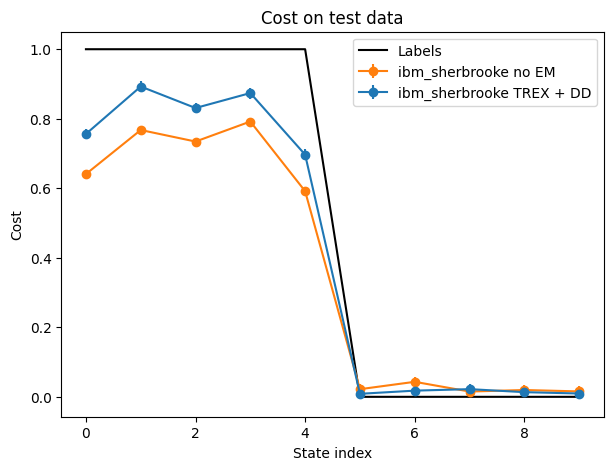

In [187]:

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

print(f"Performance for no DD + no TREX: {compute_performance(results_test_0_DD, list_labels):.3f}")
print(f"Performance for DD + TREX: {compute_performance(results_test_1_DD, list_labels):.3f}")
ax.errorbar(range(10), results_test_0_DD, fmt='-o', yerr=errors_test_0_DD, color='tab:orange', label='ibm_sherbrooke no EM')
ax.errorbar(range(10), results_test_1_DD, fmt='-o',  yerr=errors_test_1_DD, color='tab:blue', label='ibm_sherbrooke TREX + DD')

ax.plot(list_labels, 'k-', label='Labels')

ax.legend() 